# Basins of attraction for Newton's Method

Consider the polynomial function $f(z)=z^3-1$.  It's pretty clear that $z=1$ is a root, which means that $z-1$ is a factor of the polynomial.  That makes quite easy easy to factor:
$$z^3-1 = (z-1)(z^2+z+1).$$
Now, let's use the quadratic forumla to find the roots of that quadratic. I guess they're 
$$z=\frac{-1\pm\sqrt{1-4}}{2} = -\frac{1}{2}\pm\frac{\sqrt{3}}{2}i.$$
So the roots of that quadratic have both real and imaginary parts. We can visualize them in the *complex plane* by plotting the real part on the horizontal axis and the imaginary part on the vertical.

(-1.2, 1.2)

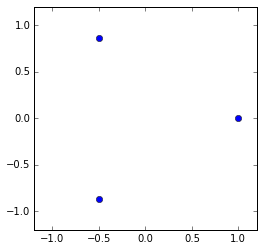

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot([1,-1/2,-1/2],[0,np.sqrt(3)/2,-np.sqrt(3)/2], 'o')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.2,1.2)

OK, here's the big question: Suppose we apply Newton's method to this function $f(z)=z^3-1$. We start at *some* point in the complex plane. The question is, to *which of these roots will be converge*? If we start *close* to one of the roots, we should converge to that root. If we start way off from all the roots, though, it's not at all clear to which root we'll converge.  One approach, to answering this question is to simply have the computer perform the process for a large number of initial seeds in a grid and then color those seed according to which root the process converged to.  Here's how.

In [9]:
import scipy as sp
from numba import jit
from timeit import default_timer as timer
from sympy import symbols, lambdify, simplify
z = symbols('z')

In [16]:
# In principle, we can set the polynomial and horizontal resolution 
# to anything we want here

f = z**3 - 1
xresolution = 800

# The example f=z**3-1 is quite standard.  Comment out one of the following lines
# to see another fun example, or define your own!
# f = z**5 - z - 0.99
# f = z**7 - 7*z**5 + 9*z**3 + 2
# f = (z**16 - 1)*((4*z)**3+1)


# And the rest should just run:
coeffs = f.as_poly().all_coeffs()
degree = len(coeffs)-1
colors = [plt.get_cmap("jet")(k/degree)[0:3] for k in range(degree)]
roots = sp.roots(coeffs)

xmin = min(roots.real)
xmax = max(roots.real)
ymin = min(roots.imag)
ymax = max(roots.imag)
xspan = max(xmax-xmin,1)
xpad = 0.2*xspan
yspan = max(ymax-ymin,1)
ypad = 0.2*yspan
xmin = xmin - xpad
xmax = xmax + xpad
ymin = ymin - ypad
ymax = ymax + ypad
xspan = xmax-xmin
yspan = ymax-ymin
dx = xspan/xresolution
yresolution = int(xresolution*(ymax-ymin)/(xmax-xmin))
dy = yspan/yresolution

n = simplify(z-f/f.diff(z))
f = jit(lambdify(z,f, 'numpy'))
n = jit(lambdify(z,n,'numpy'))

@jit()
def newton_iteration(z1, roots):
    z = z1 + 0.0j
    cnt = 0
    while np.abs(f(z))>0.1 and cnt<100:
        z = n(z)
        cnt = cnt+1
    z = n(n(z))
    
    current_idx = 0
    idx = 4
    for root in roots:
        if np.abs(z-root)<0.1:
            idx = current_idx
            break
        else:
            current_idx = current_idx + 1
    
    return (idx,cnt)

@jit
def newton_image(image, roots, colors, xresolution,yresolution, xmin,ymin, dx,dy):
    for i in range(xresolution):
        x = xmin + i*dx
        for j in range(yresolution):
            y = ymin + j*dy
            (idx,cnt) = newton_iteration(complex(x,y), roots)
            for k in range(3):
                image[j,i,k] = colors[idx][k]*(1-cnt/100)**4

In [17]:
image = np.zeros((yresolution, xresolution, 3))
t = timer()
newton_image(image, roots, colors, xresolution,yresolution, xmin,ymin, dx,dy)
timer()-t

1.8197942200349644

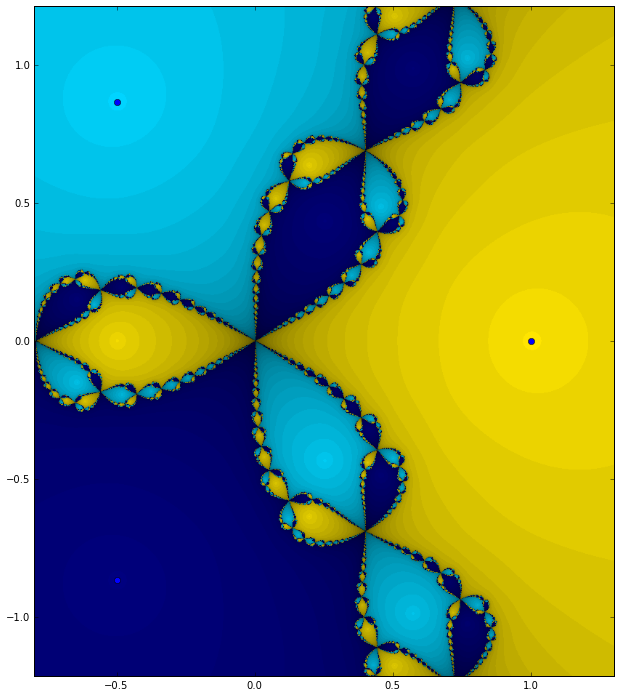

In [18]:
plt.imshow(image, extent=[xmin,xmax,ymin,ymax])
plt.plot(roots.real,roots.imag, 'o')
fig = plt.gcf()
fig.set_size_inches((12,12))
ax = plt.gca()
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax);

Here's what you get for $f(z) = z^5 - z - 0.99$:

<img src="crazy_newton.png">